In [1]:
import os
import torch
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, Tuple, Optional, List

In [2]:
os.chdir('..') # change working directory to root

In [3]:
from agents.td3 import TD3
from agents.d3qn import D3QN
from mdp.mimic_iii.reward_functions.abstract_reward_function import AbstractRewardFunction
from mdp.mimic_iii.reward_functions.factory import Factory as RewardFnFactory
from mdp.mimic_iii.action_spaces.discrete import Discrete as DiscreteActionSpace
from mdp.mimic_iii.state_spaces.sparse_autoencoder import SparseAutoEncoder as MimicIIISparseAutoEncoderStateSpace
from ope.behavior_policies.kmeans_sarsa import KMeansSarsa
from utilities import mimic_iii_funcs
from utilities.device_manager import DeviceManager

In [4]:
# reward function details dict
reward_fn_details_dict = {
    'sparse': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/vm/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '97629e709d7f45ec851200c6b0d497df',
        'd3qn_run_id': '5944007810ef4e318106533adbd6ccb6',
        'd3qn_magic_run_id': '85de6b80c8374e489bb49164bcbf29a5',
        'ddpg_run_id': 'cba965ed952945a1a0d9660d807cf2a0',
        'ddpg_magic_run_id': 'f835cde18011478693931ecc0247df63',
    },
    'wu': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '6dd75e96646b45938f225f3964705324',
        'd3qn_run_id': '5d140bdb06e344bd888876561f010f0e',
        'd3qn_magic_run_id': 'fd3f75118286426f88ca127246e33cda',
        'ddpg_run_id': '67c02a6bab0b4d74aadf585f7c8edd87',
        'ddpg_magic_run_id': '18ed010dada041f79639230d54ca5db7',
    },
    'yong': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': 'ecac4334f1994260b2bcd420b671c53a',
        'd3qn_run_id': '8f098fb13a5b41da9e77dac2ae13d321',
        'd3qn_magic_run_id': '29ad84ac64ed4ab98f7e10488887f301',
        'ddpg_run_id': '30cccf0e3c2c4ffaa1a9ea1c2bf23972',
        'ddpg_magic_run_id': '7ecad48fb0e04388b048d183b195e5f8',
    },
    'raghu': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '17d5de3272cb4e2892e6e438d22c2af4',
        'd3qn_run_id': '9a5d00e3454840499ce4697fa6bf472c',
        'd3qn_magic_run_id': 'd2584eef61284bc4bc9d57402927b750',
        'ddpg_run_id': 'da45045dfb1042d1a21a06360ca55239',
        'ddpg_magic_run_id': '01c5faa0f8ee4a5b9cb08a712060dc0e',
    },
    'peng': {
        'mlflow_base_path': '/Users/larry/Documents/UWT/Thesis Work/rec_sys/models/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '1e6330b7604f4aad8da905239c1b5070',
        'd3qn_run_id': '37d3ea87328d4c94a75c5d6e0011495a',
        'd3qn_magic_run_id': '68161afeb1ff41bbbc795f91e6a42c5b',
        'ddpg_run_id': 'b008b48ce39d4847ae2d377b4cbb91ba',
        'ddpg_magic_run_id': '2d6c08b95c8e40c2a6a0473a3b12f737',
        'reward_fn_run_id': '211c5a3c31f147f38d63b6b357a7b610',
    },
}

In [5]:
def load_split_reward_train_data(split_: int, reward_fn_name_: str, reward_fn: AbstractRewardFunction) -> np.ndarray:
    # load and preprocess mimic data
    discrete_mimic_df = mimic_iii_funcs.load_standardized_mimic_data(split_, reward_fn.raw_data_columns)
    if reward_fn_name_ != 'peng':
        reward_fn.update_rewards(discrete_mimic_df)  # scale rewards
        discrete_mimic_df = mimic_iii_funcs.drop_all_raw_data_columns(discrete_mimic_df)
    discrete_mimic_df, discrete_min_max_scaler, _ = mimic_iii_funcs.preprocess_mimic_data(discrete_mimic_df, 'iql_discrete')
    if reward_fn_name_ == 'peng':
        reward_fn.update_rewards(discrete_mimic_df)  # scale rewards
    rewards = discrete_mimic_df['r:reward'].to_numpy()
    return rewards

def load_reward_fn(reward_fn_name_: str, reward_fn_results_dict_: Dict[str, str], split_: int) -> AbstractRewardFunction:
    reward_fn_ = RewardFnFactory.create(reward_fn_name_)
    if reward_fn_name_ == 'peng':
        peng_run_id = reward_fn_results_dict_['reward_fn_run_id']
        reward_fn_.load(f'runs:/{peng_run_id}/split_{split_}')
    return reward_fn_

def do_reward_plot(reward_fn_name_: str, reward_fn_details_dict_: Dict[str, Dict[str, str]], split: int = 0):
    reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name_]
    mlflow_path = reward_fn_results_dict['mlflow_base_path']
    mlflow.set_tracking_uri(mlflow_path)
    reward_fn = load_reward_fn(reward_fn_name_, reward_fn_results_dict, split)
    rewards = load_split_reward_train_data(split, reward_fn_name_, reward_fn)
    ax = sns.displot(rewards, kind='kde')
    plt.show()
    
def do_all_reward_plots(reward_fn_details_dict_: Dict[str, Dict[str, str]], reward_fn_names: List[str] = ['sparse', 'wu', 'yong', 'raghu', 'peng'], split: int = 0):
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    rewards_df = pd.DataFrame()
    for reward_fn_name_ in reward_fn_names:
        reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name_]
        mlflow_path = reward_fn_results_dict['mlflow_base_path']
        mlflow.set_tracking_uri(mlflow_path)
        reward_fn = load_reward_fn(reward_fn_name_, reward_fn_results_dict, split)
        rewards = load_split_reward_train_data(split, reward_fn_name_, reward_fn)
        rewards_df[reward_fn_name_] = rewards
    # sns.displot(rewards_df, kind='kde', ax=ax)
    sns.kdeplot(data=rewards_df, ax=ax)#, common_norm=False, common_grid=True)
    ax.grid(False)
    ax.set_xlabel('Reward')
    # ax.set_xlim([rewards_df.min().min() - 4, rewards_df.max().max() + 4])
    plt.show()

2024/09/16 14:06:54 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


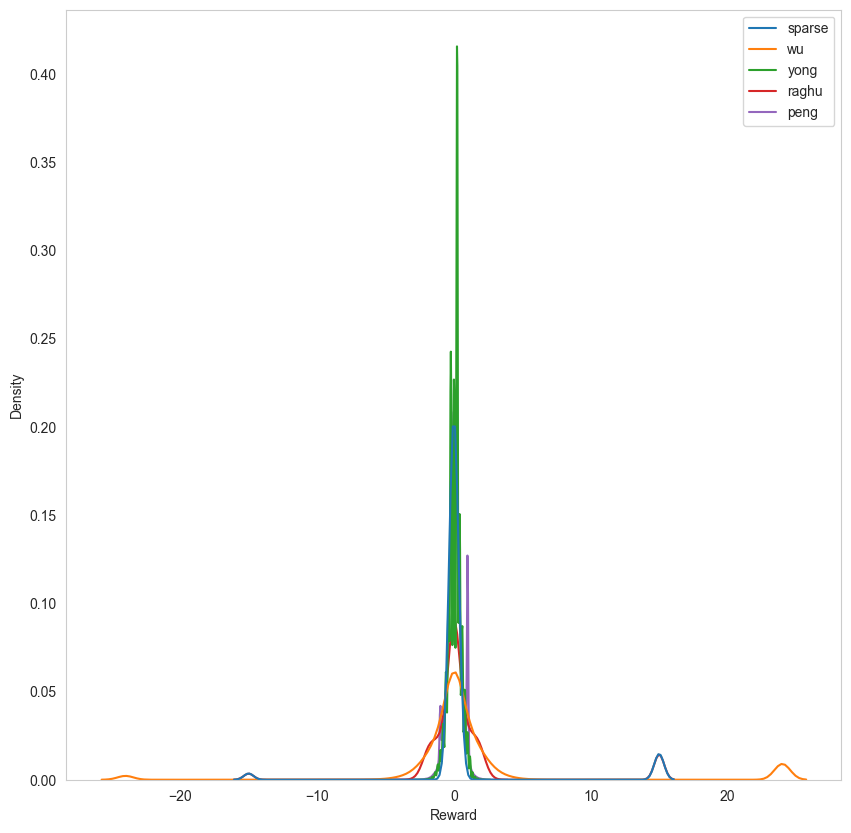

In [6]:
do_all_reward_plots(reward_fn_details_dict)

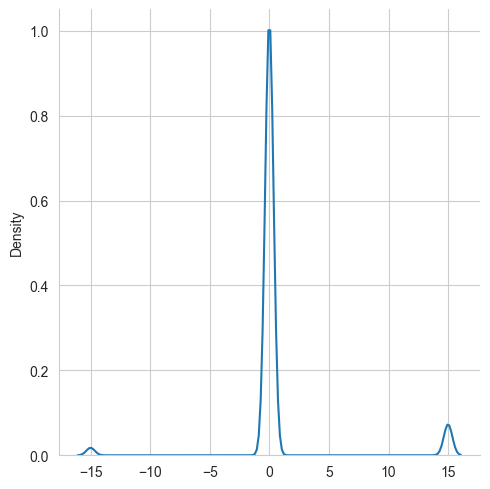

In [7]:
do_reward_plot('sparse', reward_fn_details_dict, split=0)

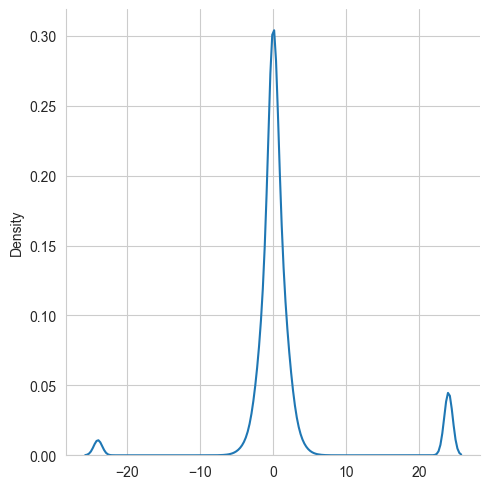

In [8]:
do_reward_plot('wu', reward_fn_details_dict, split=0)

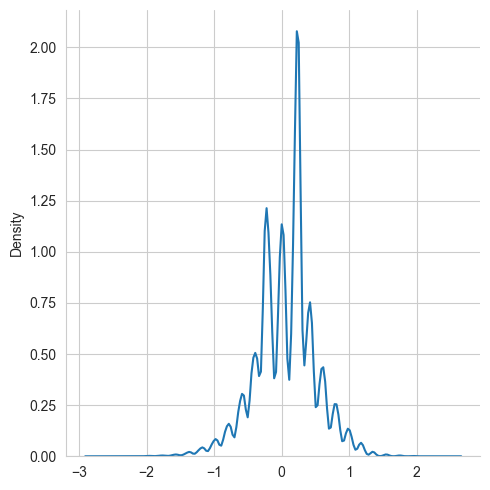

In [9]:
do_reward_plot('yong', reward_fn_details_dict, split=0)

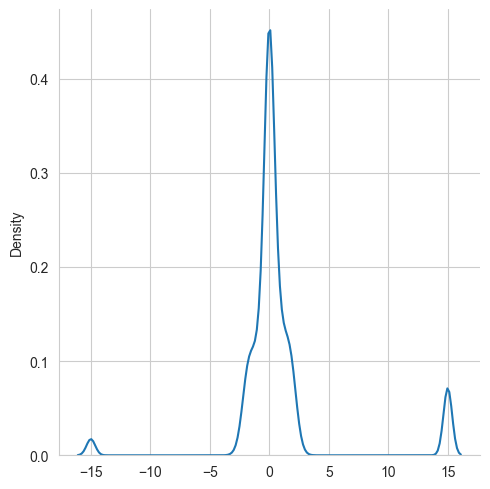

In [10]:
do_reward_plot('raghu', reward_fn_details_dict, split=0)

2024/09/16 14:07:17 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'


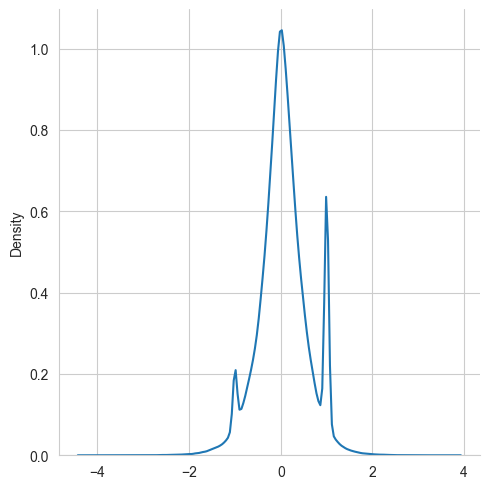

In [11]:
do_reward_plot('peng', reward_fn_details_dict, split=0)